In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns


# from econml.dml import CausalForestDML
from sklearn.model_selection import train_test_split

## Evaluation Metrics
# from causalml.metrics import auuc_score, qini_score

# import shap
import matplotlib.pyplot as plt
import seaborn as sns

## Visualisation Metric

from xgboost import XGBClassifier, XGBRegressor

___

# 0. Introduction to heterogeneous treatment effects (HTE)

Modelling of treatment effect heterogeneity attempts to go beyond just the average treatment effect and identify the treatment effects conditional on the covariates. In mathematical terms it goes from $ \tau = E[Y_{i}(1) - Y_{i}(0)]$ to $ \tau(X) = E[Y(1) - Y(0) | X]$. The motivation behind this effort is that a lot of interventions have a low average treatment effect on the whole population which renders the intervention economically unsustainable but can have a substantial treatment effect on some parts of the population such that if they were applied to them only, it would be commercially quite profitable. Thus, capturing this heterogeneity allows companies to do *targeting*, i.e., offer their discounts/incentives/advertisements to only that part of the population which is most likely to generate further profits.

Broadly speaking, the first fundamental question to ask when modelling HTE, is what kind of dataset is available. There are two fundamental categories, **observational** data and **experimental** data. The difference between these two types is severe! Observational datasets are more difficult to analyse and require more and stricter assumptions (in particular, assumptions about the data generating process) for trusting the estimates. Experimental datasets on the other hand ,i.e., data that comes from randomized experiments (RCTs), are generally more trustworthy and useful because the test design a) is known and b) allows for randomization of the other unobserved variables that could influence the outcome of interest. a) allows us to properly (and fully) deconfound the dataset by conditioning exactly on the variables that were used to construct the treatment assignment rules. b) allows us to trust our estimates because the rest of the factors that are not observed can still be randomized because of the experimental design.

In this case, the dataset comes from a field experiment, hence we are dealing with HTE in experimental (i.e., randomized) data.

Over the past years, the scientific literature has formalized and brought forward many new techniques that are optimized for estimating the (unobservable) heterogeneous treatment effects both in experimental and observational datasets. Below we will dicsuss the most popular ones, which can be divided into two broad categories: the direct learners and the indirect learners


Meta-Learners is a category of methodologies that estimate the conditional avearage treatment effect $\text{CATE}$ by first predicting the potential outcomes for each treatment, and then taking the difference between them. In contrast to Meta-Learners, other approaches attempt to model the treatment effect directly, without estimating the individual potential outcomes first (e.g., CausalForests, Double Machine Learning). The most basic Meta-Learners (S-Learner, T-Learner) use the typical machine learning setting to estimate the potential outcomes. The more advanced Meta-Learners use  results from semiparametric statistics to overcome confounding issues which are important in causal inference.



1. **Indirect methods (Meta Learners)**
- S-Learner
- T-Learner
- X-Learner
- R-Learner
- DR-Learner



2. **Direct Methods**
- Double Machine Learning
- Causal Forests
- Transformed outcome




## Assumptions for the identification of Conditional Average Treatment Effects 

The fundamental problem of causal inference and individual treatment effect ($\text{ITE}$) estimation is that for any given sample, the response is observed for only one treatment value (in A/B tests that means either treatment A or treatment B). Hence the $\text{ITE}$ is not observed and cannot be modeled as an outome variable using typical machine learning. The closest thing we can do is to take the difference of the responses of samples which are similar with respect to their covariate profile $X$. This is called $\text{CATE}$ (Conditional Average Treamtent Effect) and approximates the $\text{ITE}$. Generally, it holds that $\text{CATE}(X) = E[\text{ITE}|X=x]$. For this approximation to be valid when we are modeling $\text{CATE}$ on a real dataset, the following assumptions need to hold.

1. Positivity/Overlap: $ 0 \leq e(X) \leq 1$, where $e(X)=\text{P}(T=1|X)$: That ensures that there are no profile areas $X$ that appear only in one of the treatment groups. Naturally, we would not be able to estimate the treatment effect of these covariate profiles.

2. Unconfoundedness/Exchangeability $ \{Y_{i}(0), Y_{i}(1)\} \perp T$  **or**
2. Conditional Uncofoundedness/Exchangeability $\big ( \{Y_{i}(0), Y_{i}(1)\} \perp T \big )| X$,


In practice, exchangeability means that if the control and treatment groups were reversed, roughly (in the  statistical notion) the same distribution of responses should have been generated, because the groups are very similar in their covariate profiles (meaning that any differences in the responses should be attributed to the treatment variable). If the exchanged response distributions are not similar, that means that another systematic difference beyond the treatment assignment exists between the two groups (unobserved confounding) which most probably affects the repsonse. Hence a causal interpretation from $T$  to $Y$ is not straightforward. Conditional Exchangeability has the same interpretation but after we condition on $X$. That allows for the treatment assignment rules to change with $X$ which creates some level of confounding; but once we condition on $X$, the treatment and control groups should again be exchangeable.

4. SUTVA (Stable Unit Treatment Value Assumption), which essentially means that there is no interference between samples.

 Companies can ensure **unconfoundedness** and **overlap** by conducting field experiments and A/B tests with known treatment assignment rules. If the teratment propensities are known apriori (as happens with experiments) the analysis of heterogeneous effects is more trustworthy because we know which variables affect treatment assignment, and we also know what the actual probabilities of being assigned to a treatment group are. That saves us the statistical errors, or worse the modelling errors, of having to estimate the treatment propensities from a vector of covariates $X$ for which we are not certain whether they have participated in the treatment assignment rules at all. In the latter case, we usually resort to doubly-robust methods (DR-Learner/R-Learner, Double Machine Learning, CausalForests etc.)

___

# 1. Read and Split Data into Train and Test set

We will be working with a real experimental dataset provided by X5 Group, a russian food retailer. [https://www.x5.ru/en/]. In the experiment, the retailer randomly chose a subgroup of the customer base and sent to half of it ($e(X)=0.5$) an SMS prompting them to perform some action. The other half did not receive any intervention (control group). The response captures whether a customer performed that action that was mentioned in the SMS and is binary. The dataset that we will use here has already been preprocessed and some feature engineering has already been conducted.

The datasets that we load are:
- $\text{X}$: the customer features ,
- $\text{T}$: the treatment indicator showing whether a customer received the sms or not ,
- $\text{Y}$ and the response indicator showing whether a customer performed the action under study or not 

In [3]:
treatment_col='treatment_flg' #name of the treatment column
outcome_col='target'          #name of the outcome column

X=pd.read_csv("X.csv", index_col=0)
Y=pd.read_csv("Y.csv", index_col=0).squeeze() # read as Series
T=pd.read_csv("T.csv", index_col=0).squeeze() # read as Series

#test_df=pd.read_csv("taus.csv")

#### 1. Customer Features

- *age*: Age of the customer
- *fis_transformed*:
- frd_transformed:
- fis_frd_dist:
- gender_F: Binary indicator of whether customer is female
- gender_M: Binary indicator of whether customer is male
- gedner_U: Binary indicator of whether customer gender is unknown
- n_orders: Total number of orders placed by the customer...
- avg_paid_per_order: Average amount paid by customer per order
- products_per_order: Average number of products per order
- avg_netto_per_order: Average amount pa
- avg_regular_points_received_per_order:Average regular points gained by the customer per order
- express_points_received_per_order: Average express points gained by the customer per order
- regular_points_spent_per_order: Average regular points spent by the customer per order
- express_points_spent_per_order: Average express points spent by the customer per order
- avg_trademarks_per_order: Average number of trademarked products per order
- avg_alcohol_products_per_order: Average number of alchoholic products per order
- is_weekend: proportion of orders placed on weekends
- time_of_day_midnight_to__m: proportion of orders placed between midnight and morning
- time_of_day_morning_to_midday: proportion of orders placed between morning and midday
- time_of_day_midday_afternoon: proportion of orders placed between midday and afternoon
- time_of_day_afternoon_night: proportion of orders placed between afternoon and midnight
- brand_score: an engineered score that captures whether a customer has beeing high end products or not
- trn_sum_from_red: Not clear what it is from the original dataset. Here it is the mean of that column over all recorded dates
- trn_sum_from_iss: Not clear what it is from the original dataset. Here it is the mean of that column over all recorded dates

**Columns**

In [94]:
print(X.columns,  '\n')

Index(['age', 'fis_transformed', 'frd_transformed', 'fis_frd_dist', 'gender_F',
       'gender_M', 'gender_U', 'n_orders', 'avg_paid_per_order',
       'products_per_order', 'avg_netto_per_order',
       'avg_regular_points_received_per_order',
       'express_points_received_per_order', 'regular_points_spent_per_order',
       'express_points_spent_per_order', 'avg_trademarks',
       'avg_trademarks_per_order', 'avg_alcohol_products_per_order',
       'is_weekend', 'time_of_day_midnight_to__m',
       'time_of_day_morning_to_midday', 'time_of_day_midday_afternoon',
       'time_of_day_afternoon_night', 'brand_score', 'trn_sum_from_red',
       'trn_sum_from_iss'],
      dtype='object') 



**Preview of customer features**

In [95]:
X.head()

,age,fis_transformed,frd_transformed,fis_frd_dist,gender_F,gender_M,gender_U,n_orders,avg_paid_per_order,products_per_order,...,avg_trademarks_per_order,avg_alcohol_products_per_order,is_weekend,time_of_day_midnight_to__m,time_of_day_morning_to_midday,time_of_day_midday_afternoon,time_of_day_afternoon_night,brand_score,trn_sum_from_red,trn_sum_from_iss
0,18,840,121,719,1,0,0,4,172.290000,7.250000,...,1.000000,0.000000,3.500000,0.0,1.000000,0.000000,0.000000,0.357730,0.000000,172.000000
1,44,809,747,62,1,0,0,22,1244.361364,24.000000,...,1.818182,1.000000,1.818182,0.0,0.227273,0.772727,0.000000,0.438039,169.000000,1231.500000
2,60,741,240,501,1,0,0,13,398.461538,7.384615,...,0.230769,0.000000,1.923077,0.0,0.230769,0.769231,0.000000,0.458446,0.000000,398.846154
3,71,832,474,358,1,0,0,65,181.697231,3.600000,...,0.169231,0.030769,0.707692,0.0,0.446154,0.538462,0.015385,0.414486,1.384615,177.738462
4,55,897,689,208,0,1,0,48,442.005417,8.125000,...,2.458333,0.187500,2.229167,0.0,0.562500,0.416667,0.020833,0.406040,19.687500,425.645833


#### 2. Treatment Assignment

In [96]:
T.head()

0    0
1    0
2    1
3    0
4    1
Name: treatment_flg, dtype: int64

#### 3. Response/Outcome Variable

In [97]:
Y.head()

0    0
1    0
2    1
3    1
4    1
Name: target, dtype: int64

___

# 2. Check Randomization

Before deciding how to proceed with modelling, it is important to verify the randomization of the data. If the data comes from an experiment that has been designed and executed correctly, then we expect the treatment assignment to be either independent of the potential outcomes, i.e., $\{Y(0), Y(1) \} \perp T$, or independent of the potential outcomes when conditioned on a subset $W$ of the observable covariates, $\big ( \{Y_{i}(0), Y_{i}(1)\} \perp T \big )| W$. This ensures the unconfoundedness or exchangeability assumption which is required for identification of the conditional average treatment effects. In our case, we know that $e(X) (=0.5)$ is constant, hence we are actually in the first case.


 In the first case, exchangeability means that the probabilities of being assigned to either the control or treatment group are approximattely the same for all samples. The probabilities of assignment to control or treatment group need not necessarily be equal. For example, it may be that 70% of samples are put to the control group, and only 30% to the test group. Ιn that case I would want the probability of being assigned to treatment to be for **all** samples around 30%. In our case-study, there is 50-50 split, so expect the probabilities to be centered around 0.5 and drop off sharply.

We can check randomization with various tools. Two of them are:

- Propensity Score Histograms

- Standardized differences

## 2.1 Propensity Score Histograms

One way is to check the histogram of the *modeled* propensity scores $\hat{e} = \hat{Pr}(T_{i}=1), i \in \{1,2,...,n\}$. In randomized data, we expect the propensities to be densely concentrated around the proportion of samples assigned to the treatment group, $ \frac{n_{T}}{n}$.

In [98]:
from sklearn.preprocessing import StandardScaler
from causalml.propensity import LogisticRegressionPropensityModel

Text(0.5, 1.0, 'Histogram of estimated propensities')

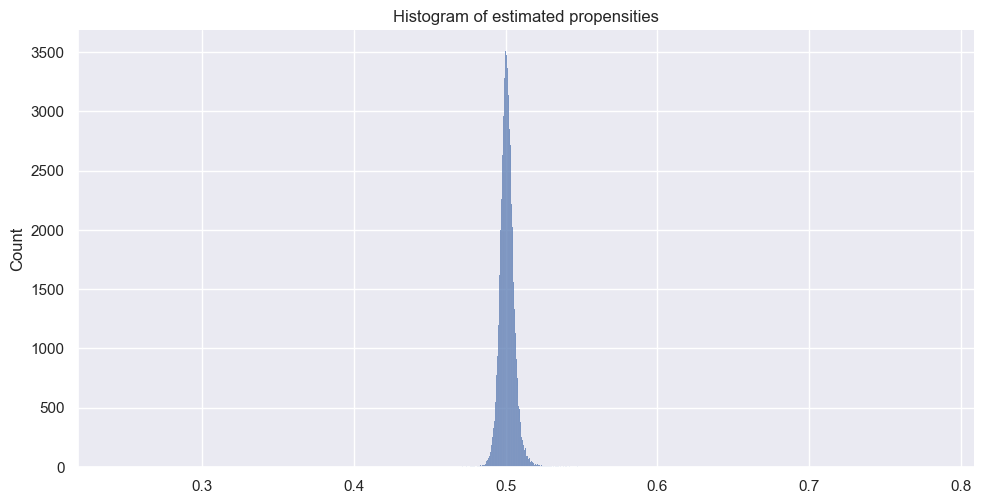

In [99]:
# Scale data (required for Lasso Logistic Regression)
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled.loc[:,:] = scaler.fit_transform(X)


prop_model = LogisticRegressionPropensityModel(penalty='l1', random_state=23) 
# Lasso logistic regression (LogisticRegressionCV in particular) with stratified 4-Fold cross-validation

prop_model.fit(X_scaled, T)
e_hats = prop_model.predict(X_scaled)

sns.displot(x=e_hats,
            height=5,
            aspect=2)

plt.title('Histogram of estimated propensities')

The histsogram is characteristic of randomized data. The variance is low and  strongly concentrated around the observed proportion of samples in the treatment group. As shown in the first line of the next table (Section 2.2), there are 99,981 samples in the treatment group and 100,058 in the control. This amounts to an overall propensity of 49.98% Hence the propensity scores in the histogram are correctly centered around/close to 0.5.

**However**, we notice that the axes span from 0.3 to 0.8 which indicates that there exist a few observations that have singificantly low or high propensities. These are probably outliers (i.e., rare samples from the population distribution, and thus only sparse in our dataset) Because these are few, it may happen that they are disproportionally placed in one of the treatment groups, even if we have an exactly 50% chance of assignment to either group (sampling error due to low number of samples with that covariate profile) We will see that the vast majority of the samples (>99%) are between 45% and 55% probabilities and we will work with those.


**Note**  

`LogisticRegressionPropensityModel` from Ubers' causalml trains a `LogisticRegressionCV` model with parameters:

- "penalty": 'l1' (default is 'elasticnet')
- "cv": 4 (Stratified)

___

Let's put the propensities and treatment indicators into a dataframe

In [100]:
prop_df= pd.DataFrame(e_hats, columns = ['propensity'])
prop_df['treatment'] = T

prop_df.head(5)

,propensity,treatment
0,0.493790,0
1,0.503944,0
2,0.494022,1
3,0.502560,0
4,0.507477,1


**Lowest propensities**

In [101]:
prop_df['propensity'].sort_values().head(15)

160362    0.244804
12989     0.254133
44116     0.288790
130397    0.290143
33454     0.291512
38829     0.293049
5786      0.294415
54525     0.414964
20738     0.433754
17820     0.445941
8500      0.446047
118852    0.446278
110139    0.450864
42270     0.453911
170777    0.454724
Name: propensity, dtype: float64

**Highest Propensities**

In [102]:
prop_df['propensity'].sort_values(ascending=False).head(15)

41352     0.781744
29778     0.768476
31117     0.739969
29235     0.663915
170033    0.663824
118863    0.662364
72226     0.650240
36158     0.646035
21273     0.643603
97085     0.642687
26321     0.641187
88315     0.634667
76954     0.632489
28117     0.631897
29697     0.629015
Name: propensity, dtype: float64

With the quantiles below, we confirm that it is only a handful of samples for which we predict very high/low propensities.

In [103]:
prop_df['propensity'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

0.1    0.495537
0.2    0.497367
0.3    0.498626
0.4    0.499682
0.5    0.500672
0.6    0.501688
0.7    0.502832
0.8    0.504257
0.9    0.506509
Name: propensity, dtype: float64

99.9% of samples are between 45% and 55%

In [104]:
len(prop_df[prop_df['propensity'].between(0.45,0.55)]) / len(prop_df)

0.9994389472610425

Below we also show that for the filtered data, the assignment probability distributions for both the treatment and the control group have a huge overlap

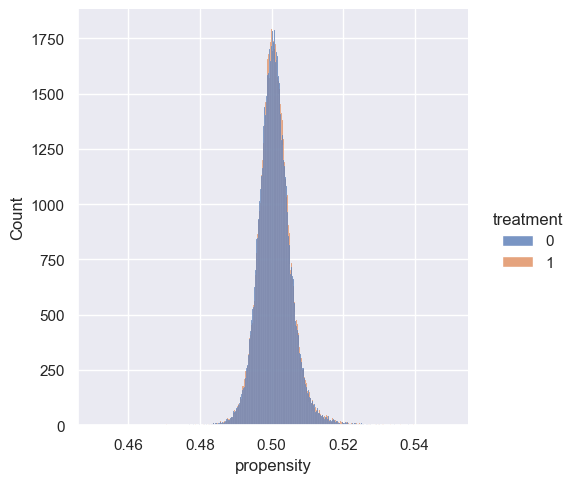

In [105]:
sns.displot(data = prop_df[prop_df['propensity'].between(0.45,0.55)],
            x='propensity',
            hue='treatment',
            alpha =0.75)

we store which indices to drop later on

In [106]:
index_to_keep = prop_df[prop_df['propensity'].between(0.45,0.55)].index

From that first check, we confirm that the data truly looks randomized with $e(X)=0.5$. Below, we use one more tool to confirm randomisation.

___

## 2.2 Standardized Mean Differences (SMDs)

Standardized Mean Differences are a simplified way of checking that covariates are randomized across treatment and control groups.  They are  calculated for each continuous covariate independetly using the formula below:

$$\text{SMD} = \frac{\bar{X}_{\text{treatment}} - \bar{X}_{\text{control}}} {\sqrt{\frac{\hat{s}^{2}_{\text{treatment}} + \hat{s}^{2}_{\text{control}}} {2}}}$$

where: 

 - $\bar{X}_{i}$ is the sample mean of the covariate under study for the treatment group $i$
 - $\hat{s}^{2}_{i}$ is the sample variance of the covariate under study for the treatment group $i$


and for each binary variable using the formula:


$$\text{SMD} = \frac{\hat{p}_{\text{treatment}} - \hat{p}_{\text{control}}}{\sqrt\frac{\hat{p}_{\text{treatment}}(1-\hat{p}_{\text{treatment}})+ \hat{p}_{\text{control}}(1-\hat{p}_{\text{control}})}{2}}$$

where: 

 - $\hat{p}_{i}$ is the sample proportion of the (Bernoulli)covariate under study for the treatment group $i$
 - $\hat{p}_{\text{i}}(1-\hat{p}_{\text{i}})$ is the sample variance of the (Bernoulli)covariate under study for the treatment group $i$  
 

**Interpretation**  
 When the SMDs are low in the sense of absolute values, the difference of the means is low compared to the pooled standard deviation. This indicates that the samples drawn for the treatment and control groups are probably drawn from the same distribution, rather than two different ones, confirming to some degree that there is randomization with respect to the observed covariates.

We can use the `create_table_one` function from Uber's causalml package to calculate quickly the SMDs for all features.

In [16]:
from causalml.match import create_table_one

In [17]:
balance_table = create_table_one(data = pd.concat([X,T.reset_index(drop=True)], axis=1),  # pass  dataframe containing the covariates X, and the treatment assignment indicator column T
                                                 treatment_col = T.name,     # pass treatment column name as a string
                                                 features = list(X.columns)) # pass covariates names as  list
balance_table

,Control,Treatment,SMD
Variable,,,
n,88055,88399,
age,46.46 (60.60),46.83 (35.63),0.0074
avg_alcohol_products_per_order,0.10 (0.21),0.10 (0.21),-0.001
avg_netto_per_order,3.10 (2.65),3.13 (3.02),0.0124
avg_paid_per_order,494.55 (371.18),496.90 (377.36),0.0063
avg_regular_points_received_per_order,4.58 (4.79),4.60 (4.89),0.0048
avg_trademarks,0.97 (0.77),0.98 (0.77),0.0091
avg_trademarks_per_order,0.97 (0.77),0.98 (0.77),0.0091
brand_score,0.43 (0.06),0.43 (0.06),-0.0031


We notice that all SMDS (last column) are well below 0.1 for all features, indicating strong randomization.


|  Important Note                         |
|-----------------------------------------|

In general, we want the full covariate profile, meaning the multivariate distribution resulting from all covariates, to be similar between the treatment and the control groups. What we are comparing here are just the means, which are only one aspect of a single variable distribution. In general, we could be more thorough in our checks and compare also the variances of the features and other higher-order moments such as kurtosis. The more metrics we find to be similar when comparing the distributions between treatment and control groups for  a feature, the more confident we are in the randomization. A quick way to summarise these comparisons is to study the histograms of each feature. Of course, that is still not a full comparison of the multivariate distribution. These comparisons refer to the marginal single variable distribtions for each feature under study (marginalizing over all other features in the multivariate distribution), and do not reveal anything about the correlations between the features themselves. However, the more *similar* the single variable distributions, the more difficult it is that only the correlations between the variables differ. Hence, if we do not find evidence of non-randomization,  especially in data coming from an experiment, we usually proceed with assuming sufficient randomization.



___

# 3. Learning  treatment effect heterogeneity

Below, we demonstrate with a simple train-test split on the data, how various $CATE$ estimators work. We begin with the easier ones and continue onwards to more sophisticated methods. We mainly rely on two libraries. Uber's `causalml` package and Microsoft's `econml`  




### First things first
We begin by showing the following theoretical result:

$\tau(x) = \text{E}[Y_{i}(1) - Y_{i}(0) |X_{i}=x] = $  
$\text{E}[Y_{i}(1)|X_{i}=x]  - \text{E}[Y_{i}(0)|X_{i}=x]=$ (because of conditional unconfoundedness $\big (\{Y_{i}(0), Y_{i}(1)\} \perp T \big )| X$)  
$\text{E}[Y_{i}(1)|T_{i}=1, X_{i}=x]  - \text{E}[Y_{i}(0)|T_{i}=0, X_{i}=x]=$  
$\text{E}[Y_{i}|T_{i}=1, X_{i}=x]  - \text{E}[Y_{i} |T_{i}=0, X_{i}=x]=$  
$\mu(T=1, x) - \mu(T=0, x)$

This means that from a theoretical standpoint one can approach estimating $\text{CATE}$ via estimating the last two models as classic nonparametric machine learning problems. The most straightforward ways to do these estimations are the S-Learners and T-learners outlined below. We will see that even though these two approaches are theoretically the go-to approaches, they often fall short beacuse of various biases that exist in the data (confounding, regularization), which has given a rise to many new approaches!
 
## Summary of the different models

#### 3.1) **Simple Meta-Learners**: S-Learner & T-Learner
The first group of models are the **S-Learner** and the **T-learner**. These models predict the outcome $\hat{Y}$ under treatment ($T=1$) and no treatment ($T=0$) for each sample based on its covariate profile $X$ and estimate $CATE(x)$ as the difference between those two predictions, $\hat{\tau}(x) = \hat{Y}(1, x) - \hat{Y}(0, x)$. In general, these two models are method-agnonstic, i.e., any off-the-self machine learning model can be used to fit the data and generate outcome predictions. They are also the simplest ones and can perform very well in cases where the **sample size is large** (relative to the number of covariates) and there is **minimal to  no confounding**. Additionally, the more even the split between the treatment and the control group (ideal scenario is 50-50), the better these two modes are expected to perform. When the split is highly imbalanced (think 30% control, 70% treatment) these two models are prone to **regularization bias**. Due to the low sample size in the minority group, data shortage in specific areas of the covariate space $X$ might lead to incorrect(regularized) outcome predictions $\hat{Y}$, thus leading to a biased estimate of the treatment effet $\tau(X)$. This happens partly due to the fact that these approaches are not optimized for predicting the difference between the outcomes, but for predicting as accurately as possible the outcomes themselves. When regularization bias exists, this discrepancy leads to inaccurate treatment effect estimation.


#### 3.2) **Meta-Learner that combats Regularization Bias**: X-Learner

The X-Learner (details about how it is constructed are presented later on) is based on the T-Learner but adds an extra step to correct for the regularization bias mentioned above. To do that, the  X-Learner requires additionally knowledge of the treatment propensities. These can either be estimated or if they are known apriori, they can be passed as input without estimation. The latter is preferred whenever possible (i.e., in experiments) because estimation of propensities propagates further statistical errors into the estimation of the treatment effects. When pronpensities need to be estimated, it is better to use doubly-robust methods which account for exactly that weakness, i.e., they shield the estimations errors of the outcome or the propensity models when at least one of the two models is not misspecified. 


#### 3.3) **Transformed Outcome for fighting Confounding Bias**: 


#### 3.4 **Doubly Robust Meta-Learners**: DR-Learner, R-Learner

THe DR(doubly-robust)-Learner and the R-Learner are two approaches for doubly-robust estimation of heterogeneous treatment effects. These are a few of the best tools we have in our disposal when we have to estimate treatment propensities as well. As stated above, doubly-robust methods shield our treatment effect estimation from statistical erros if at least one of two models, the outcome or the propensity models, is correctly specified. 

THe R-Learner is powerful because it connects $\tau(x)$ to the prediction of the outcome variables $Y$. As a result, it provides us with

**Important Note**: When estimating the propensity scores, i.e., when the treatment assignment rules are not known to us, then we face one more (super)important problem beyond the estimation errors of the statistical modeling. We are not certain which of the observed covariates have played a role in the treatment assignment. Attempting to include all of them in the propensity model gives rise to two problems, one less detrimental than the other. The first and more minor problem is that we might increase our estimation errors when we attempt to include many irrelevant features, especially when the sample size is small, which in turn affects our treatment effect estimations. The second, and far more serious, problem, is that we might (unknownignly) condition on (i.e., account for) a variable that will generate a new type of bias called collider bias. Collider bias is outside of the scope of this document, but it can severly bias the results to the point that it reverses the direction of the true treatment effects.


#### 3.5) Double Machine Learning (to be added)

#### 3.6) Causal Forests (to be added)


___

## Train-Test Split

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(pd.concat([X,T],
                                                              axis=1),
                                                    Y,
                                                    test_size=0.35, 
                                                    random_state=111)


T_train = X_train.iloc[:,-1]
T_test = X_test.iloc[:,-1]
X_train = X_train.iloc[:,:-1]
X_test  = X_test.iloc[:,:-1]

## 3.1 S-Learner


An S-learner estimates the $\text{CATE}$, $\hat{\tau}(x) = E[Y(1)-Y(0)|X=\bold{x}]$, with a single machine learning model $\hat{\mu}(\bold{x}, t)$  
$\hat{\mu}(x)$ is estimated by regressing $Y$ against $X$ and $T$:   $\hat{\mu}(\bold{x},t) = E[Y|X=x, T=t]$  
$\text{CATE}$ is then estimated  via $\hat\tau(x) = \hat{\mu}(\bold{x}, 1) - \hat{\mu}(\bold{x}, 0)$

**Notes**  

- For the regression, any machine learning model can be used (e.g., Random Forests, Gradient boosted trees, linear regression etc.)
- S-Learner is also prone to regularization bias, i.e., when there is fewer samples in one of the treatment groups, regularized machine learning models (lasso, svms, tuned random forests etc.) tend to bias the treatment effect towards 0.


Though the S-Learner is intuitive and simple, it may be unable to capture the effect of the treatment of interest when that effect is low (albeit statistically significant), compared to the influence of some other covariates in $X$. To visualise this in our minds, we can picture a tree-based algorihtm that never chooses to split on $T$. Therefore, the estimated treatment effects are often biased towards 0 with this learner.

In [52]:
from causalml.inference.meta import BaseSClassifier  # uber has an S-Learner that predicts
from econml.metalearners import SLearner  #econml's S-Learner uses a regressor (no classifier yet)

#### causalml

In [53]:
## S-LEARNER
s_learner = BaseSClassifier(learner = XGBClassifier(),  # pass the model to be used for estimating the machine learning model
                           control_name=0)             # pass the value indicating the control group assignment


# fit model
s_learner.fit(X=X_train,
              treatment=T_train, 
              y=Y_train)


# predict treatment effct
tau_s = s_learner.predict(X_test)


# predicted treatment efects on X_test from causalml's S-Learner (classifier)
tau_s

array([[ 0.00735003],
       [-0.01287693],
       [-0.00853223],
       ...,
       [ 0.06250969],
       [ 0.01890957],
       [ 0.0271633 ]])

#### econml

In [54]:
s_learner_ec = SLearner(overall_model=XGBRegressor(random_state=3))

s_learner_ec.fit(X=X_train,
        Y=Y_train,
        T=T_train)

tau_s_ec = s_learner_ec.effect(X_test)

tau_s_ec = tau_s_ec.reshape((len(tau_s_ec),1))

# predicted treatment efects on X_test from ecoml's S-Learner
tau_s_ec

array([[-0.01515037],
       [-0.0138666 ],
       [ 0.00596642],
       ...,
       [ 0.05146295],
       [ 0.02608192],
       [-0.10128075]])

____

# 3.2 T-Learner

A T-learner estimates the CATE $E[Y(1)-Y(0)|X=x]$ via **two** models $\hat{\mu}_{1}(x), \hat{\mu}_{0}(x)$, 

where $\hat{\mu}_{t}(x) = E[Y|X=x, T=t]$ is a model that predicts outcome $Y$ given covariates $X$ and treatment $t$, and has been trained on the samples that received treatment $t$

The T-Learner overcomes the problem of the S-Learner (not giving enough weight on the treatment variable) by training two different models, one for each treatment group (for multiple discrete treatments, one fits multiple models)

Still, the main problem of the T-Learner is that it will perform poorly when there is local sparsity of data in at least one of the treatment groups because of the regularization bias. In particular, if we look at the image below, we will see that covariate $x$ has a different distribution for those who have received treatment ($a==1$, left image) and those who have not ($a==0$, right image)., i.e., there is confounding. While in reality there is zero treatment effect (line $\text{Truth}$ is the same in both graphs), the individual machine learning models in each group fit the response poorly in the $x$-regions where data is sparse. Hence, the difference of these two lines will reveal a treatment effect which would be false.

![Screenshot 2024-02-10 at 2.39.32 PM.png](<attachment:Screenshot 2024-02-10 at 2.39.32 PM.png>)

Photo from: Edward H. Kennedy. Optimal doubly robust estimation of heterogeneous causal effects. 2020. arXiv:2004.14497.
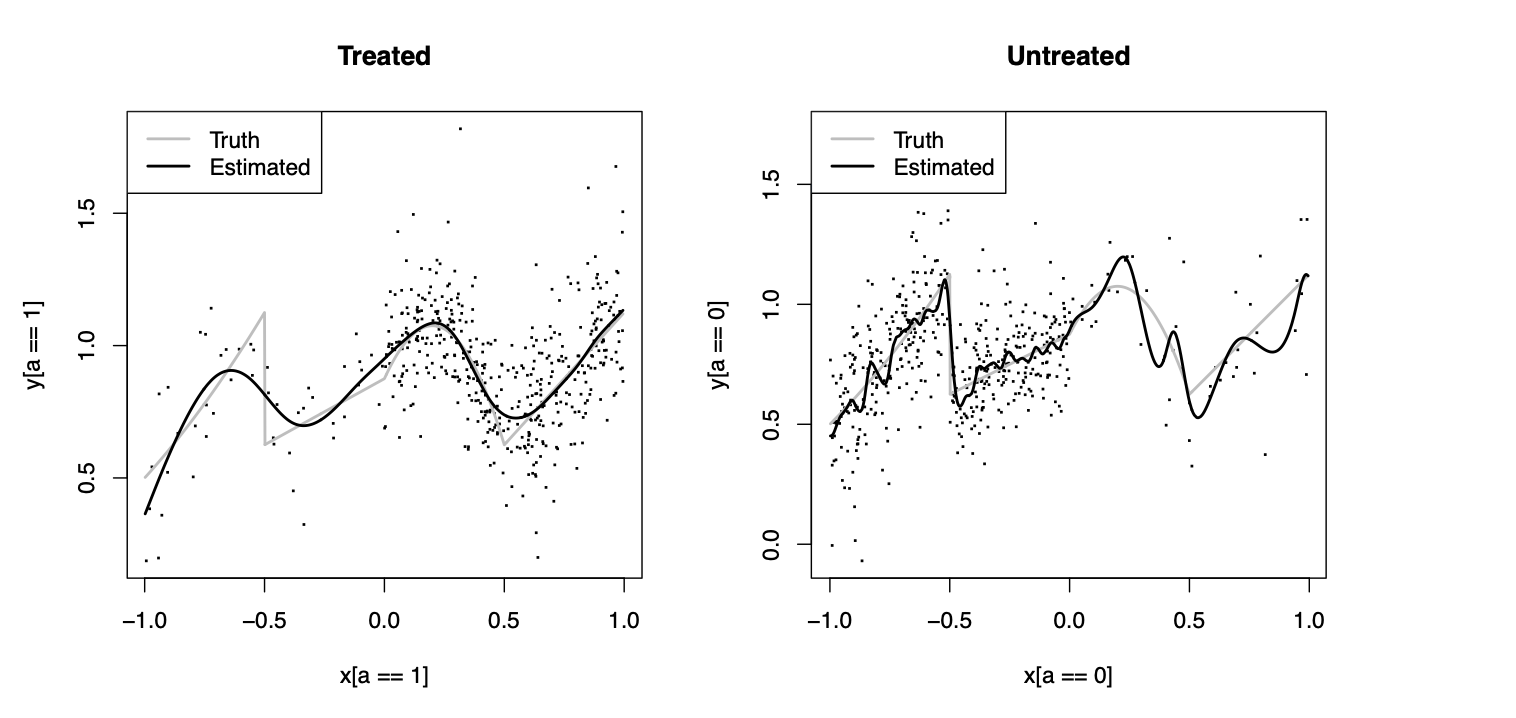

___

In [55]:
from causalml.inference.meta import BaseTClassifier
from econml.metalearners import TLearner

#### causalml

In [56]:
# T-LEARNER
t_learner = BaseTClassifier(control_learner = XGBClassifier(),   # pass the model to be used for estimating  mu_0 
                            treatment_learner = XGBClassifier(), # pass the model to be used for estimating  mu_1
                            control_name=0)                      # pass the value indicating the control group assignment (check values in your treatment vector)



# fit model
t_learner.fit(X=X_train,
              treatment=T_train, 
              y=Y_train)

# predict treatment effct
tau_t = t_learner.predict(X=X_test)

tau_t

array([[-0.02534071],
       [ 0.11264169],
       [-0.14861494],
       ...,
       [ 0.00373071],
       [ 0.02855068],
       [ 0.18631527]])

#### econml

In [57]:
# instantiate T-Learner
t_learner_ec = TLearner(models=XGBRegressor()) # pass the model to be used for estimating  mu_0 

# fit model
t_learner_ec.fit( X=X_train,
                  Y=Y_train,
                  T=T_train)

# predict on X_test
tau_t_ec = t_learner_ec.effect(X=X_test)

# reshape
tau_t_ec = tau_t_ec.reshape((len(tau_t_ec),1))

# predicted treatment efects on X_test from ecoml's T-Learner
tau_t_ec


array([[-0.21723285],
       [-0.01230657],
       [-0.03185332],
       ...,
       [ 0.04697412],
       [ 0.13009197],
       [-0.04887729]])

____

## 3.3 X-Learner

The X-Learner makes a first move towards alleviating the regularization bias found in the S and T Learners. It calculates $\text{CATE}$ as follows.

1. As in the T-Learner, it begins by training two outcome models, $\hat{\mu}_{1}(\bold{x}), \hat{\mu}_{0}(\bold{x})$
2. It uses $\hat{\mu}_{1}(\bold{x}), \hat{\mu}_{0}(\bold{x})$ to calculate two new models, $\hat{\tau}_{i}^{1}(x), \hat{\tau}_{i}^{0}(x)$, each of which estimates the $CATE(x)$ seperately.  

    -  $\hat{\tau}_{i}^{1}(x)$ is trained using only the treated samples and $\hat{\mu}_{0}(\bold{x})$: $\hat{\tau}_{i}^{1}(x) =  Y_{i}^{obs}  - \hat{\mu}_{0}(\bold{x}_{i})$
    -  $\hat{\tau}_{i}^{0}(x)$ is trained using only the control samples and $\hat{\mu}_{1}(\bold{x})$: $\hat{\tau}_{i}^{0}(x) = \hat{\mu}_{1}(\bold{x}_{i}) - Y_{i}^{obs} $  
    
3. $\text{CATE}(x)$ is estimated via weighting the individual effect predictions, $\hat{\tau}_{i}^{1}(x), \hat{\tau}_{i}^{0}(x)$,  based on the estimated propensity score of the sample under study: $$\hat{\tau}(x)=\hat{e}(x) \cdot \hat{\tau}^{0}(x) + (1-\hat{e}(x)) \cdot \hat{\tau}^{1}(x)$$

*Note*: The logic of the weighting in step is 3 is that when $\hat{e}(x)$ is large (closer to 1) then samples with covariates $X=x$ are (much) more frequent in the treated group, and hence the outcome estimator $\hat{\mu}_{0}(X=\bold{x})$ is more accurate than $\hat{\mu}_{1}(X=\bold{x})$ in the area around $X=x$. That happens because the more samples exist around the area $X=x$, the better the modeling of the outcome in that area. By extension, the treatment effect estimated by  $\hat{\tau}^{0}(x)$ - which is based on $\hat{\mu}_{1}(X=\bold{x})$ and the true observed responses of the few/sparse control samples- is expected to be more accurate than the effect estimated by $\hat{\tau}_{i}^{1}(x)$.  Conversely, when $\hat{e}(x)$ is low (i.e., closer to 0), then $(1-\hat{e}(x))$ is large, and the estimation of $\hat{\tau}^{0}(x)$ (based on $\hat{\mu}_{0}(x)$) becomes more accurate.

The X-Learner thus usually outperforms the T-Learner in cases where there is sparsity of various covariate profiles in either treatment group.

Here, we see that the propensity scores need to be estimated as well. In our case, we do know that $e(X)=0.5$ and we will use that.


___

In [58]:
from causalml.inference.meta import BaseXClassifier
from econml.metalearners import XLearner

#### causalml

In [59]:
# initiate model
x_learner = BaseXClassifier(control_outcome_learner=XGBClassifier(),
                            treatment_outcome_learner=XGBClassifier(),
                            control_effect_learner= XGBRegressor(),
                            treatment_effect_learner= XGBRegressor(),
                           control_name=0)


# for the X-Learner, we need to either estimate propensities or if they are known, to pass them as input
ehat_train = 0.5* np.ones((len(X_train),))
ehat_test= 0.5* np.ones((len(X_test),))

# fit model
# careful: if you do not pass propensity scores, ElasticNet will automatically be called.
# here, we know the sparsity scores 
x_learner.fit(X= X_train,
              treatment= T_train,
              y= Y_train,
              p= ehat_train)

# predict effects
# careful: if you do not pass propensity scores, ElasticNet will automatically be called.
tau_x = x_learner.predict(X_test,
                          p=ehat_test)

#### econml

Unfortunately, in the econml implementation of the X-Learner, the propensity scores have to be estimated, or one has to write a new class with a .predict_proba() method that would return the known propensities..

In [60]:
x_learner_ec = XLearner(models =          [XGBClassifier(), XGBClassifier()],
                        cate_models =     [XGBRegressor(), XGBRegressor()],
                        propensity_model=  XGBClassifier())


x_learner_ec.fit(X=X_train,
                 Y=Y_train,
                 T=T_train)

tau_x_ec = x_learner_ec.effect(X_test)
tau_x_ec = tau_x_ec.reshape((len(tau_x_ec),1))
tau_x_ec

array([[-0.02722277],
       [ 0.10113402],
       [-0.07082249],
       ...,
       [-0.05284443],
       [-0.03785519],
       [-0.33838362]])

____

## 3.4 DR-Learner


The DR-Learner introduces the pseudo-outcomes $\phi$ and estimates the $CATE(x)=\hat{\tau}(x)$ by regressing the pseudo-outcomes $\phi_{i}$ against covariates $X$: $\hat{\tau}(x) =  E[\phi|X=x]$  
The DR-Learner and the scores $\phi$ that it is built upon can be viewed as a correction to the T-Learner.  
For each sample $i$, the pseudo outcome $\phi$ is calculated with the following formula:

$$\phi_{i} = \hat{\mu}_{1}(x_i) - \hat{\mu}_{0}(x_i) + \frac{T_i-\hat{\pi}(x_{i})}{\hat{\pi}(x_{i})(1-\hat{\pi}(x_{i}))} (Y_i - \hat{\mu}_{T_i}(x_i)) $$


Notice that the term $\hat{\mu}_{1}(x_i) - \hat{\mu}_{0}(x_i)$ is in essence the T-Learner. The leftover term $\frac{T_i-\hat{\pi}(x_{i})}{\hat{\pi}(x_{i})(1-\hat{\pi}(x_{i}))} (Y_i - \hat{\mu}_{T_i}(x_i))$ can be viewed as a correction to the T-Learner estimation.  

Upon closer inpsection of the correction term we notice that:
 -  if $t_i=1$, then the terms $1-\hat{\pi}(x_{i})$ in the numerator and denominator will cancel out and the correction term becomes: $\frac{1}{\hat{\pi}(x)} (Y_i - \hat{\mu}_{1}(x_i))$
 -  if $t_i=0$, then the terms $ \hat{\pi}(x_{i})$ in the numerator and denominator will cancel out and the correction term becomes: $ - \frac{1}{(1-\hat{\pi}(x))} (Y_i - \hat{\mu}_{0}(x_i))$

These correction terms have a big influence if either 1/denominator or the difference in the parenthesis are large (or both).

 - 1/denominator is moderately large when the sample under consideration is representative of both groups and very large when it is representative for the group that it was **not** assigned to. Conversely, samples who are mostly representative for the group that they were assigned to will have a low value for 1/denominator as denominator will be close to 1 (say 0.8, 0.9)
 - The numerator is large (in absolute value) when the outcome $Y_{i}$ is different than the conditional expected outcome in the group it belonged to, $E[Y|X=x_i, T=t_i]$  



In [61]:
from econml.dr import DRLearner

In [62]:
dr_learner = DRLearner(model_propensity=XGBClassifier(),
                       model_regression=XGBClassifier(),
                       model_final=XGBRegressor(),
                       discrete_outcome=True)


dr_learner.fit(X=X_train,
               T=T_train,
               Y=Y_train)


tau_dr = dr_learner.effect(X_test)
tau_dr = tau_dr.reshape((len(tau_dr),1))
tau_dr

array([[-0.12259948],
       [ 0.05103425],
       [-0.05618949],
       ...,
       [ 0.30305633],
       [ 0.23434591],
       [ 0.08555649]])

___

## 3.5 R-Learner (Theory pending)

Main Equation: $Y_i - m^{*}(x) = \{W_{i}-e^{*}(x)\} \cdot \tau^{*}(x) + \epsilon_{i}$

where

- $m^{*}(x)= E[Y|X=x] $  
- $\epsilon_{i} = \epsilon(w) = Y(w) - \big \{ \mu^{*}_{0}(x) + w\tau^{*}(x) \big \}$
- 


$\tau(\cdot) = \text{argmin}_{\tau}  \big[\frac{1}{N} \sum_{i=1}^{N} \big]$


Unfortunately, the econml library does not support discrete outcome modeling yet in its R-Learner

In [63]:
from causalml.inference.meta import BaseRClassifier

In [64]:
r_learner = BaseRClassifier(outcome_learner=XGBClassifier(),
                            effect_learner= XGBRegressor())


# for the X-Learner, we need to either estimate propensities or if they are known, to pass them as input
ehat_train = 0.5* np.ones((len(X_train),))
ehat_test= 0.5* np.ones((len(X_test),))

r_learner.fit(X=X_train,
              treatment=T_train,
              y=Y_train,
              p=ehat_train)


tau_r = r_learner.predict(X_test,
                          p=ehat_test)

tau_r = tau_r.reshape((len(tau_r),1))
tau_r

array([[ 0.10502863],
       [ 0.01104329],
       [-0.08001481],
       ...,
       [-0.00384497],
       [ 0.11129234],
       [ 0.02182915]])

____

## 3.6 Transformed Outcome 

When the propensity scores $e(X)$ are known, then the estimator $Y^{*} = \frac{T_i - e(X_i)}{e(X_i)\cdot (1-e(X_i))}\cdot Y_i $ is an unbiased estimator of the counterfactual outcome $Y(T)$.   

This means that $E[Y^{*}|X] = E[Y(1)-Y(0)|X] = \tau(X)$

Αs the regression model to be fitted to the transformed outcome aims directly at cautpring the treatment effect, I am also conducting some fine-tuning on the xgbregressor here.

In [65]:
Y_train_tr = (T_train - 0.5) / (0.5**2) * Y_train
Y_test_tr = (T_test - 0.5) / (0.5**2) * Y_test

In [66]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [67]:
# Perform grid search with cross-validation
to_tuned= GridSearchCV(estimator=XGBRegressor(random_state=3), 
                        param_grid={
                            'n_estimators': [300, 600, 800, 1000],
                            'learning_rate': [0.2, 0.5],
                            'max_depth': [3, 5, 7, 10]}, 

                        cv=KFold(n_splits=5, shuffle=True, random_state=42), 
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=-1)

to_tuned.fit(X_train, Y_train_tr)

# Get the best parameters and the best score
best_params = to_tuned.best_params_
best_score =  to_tuned.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

# Evaluate the tuned model on the test set
tuned_model = to_tuned.best_estimator_

tau_to = tuned_model.predict(X_test)


tau_to = tau_to.reshape(len(tau_to),1)
tau_to

Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}
Best Accuracy: -1.5779238762437984


array([[-0.07794587],
       [ 0.03459261],
       [-0.03604013],
       ...,
       [-0.07890575],
       [-0.37111863],
       [ 0.18827297]], dtype=float32)

## 3.7 Double Machine Learning (Theory pending)

Double Machine Learning is based on the idea of estimating treatment effects (and heterogeneity) by regressing the error signal between 

In [68]:
# Main imports
from econml.dml import DML, LinearDML

In [69]:
dml = LinearDML(model_y= XGBClassifier(),
                model_t= XGBClassifier(),
                discrete_treatment=True,
                discrete_outcome=True,
                random_state=123)

dml.fit(Y_train, T_train, X=X_train)
tau_dml = dml.effect(X_test)

## 3.8 Causal Forests


Causal Forests is an algorithm that attempts to find heterogeneity in treatment responses based on the covariates. As the name suggests, its structure is very similar to that of Random Forests.

The main difference to the Random Forests algorithm is the splitting criterion. While in RF, the chosen split maximizes the reduction in the sum of squared errors between predictions and true values, in causal forests the splitting criterion maximizes for treatment heterogeneity, in other words, the difference in the treatment effects found in the two new nodes. If $\tau_{1}$ and $\tau_{2}$ are the treatment effect estimations in two new candidate nodes 1,2 respectively, then the criterion will choose the split that maximizes a proxy of heterogeneity $(\tau_{1}-\tau_{2})^2$

An important note regarding Causal Forests, is that before it starts building the tree, it uses a preprocessing technique that *deconfounds* the data as much as possible. The theme is that of the Double Machine Learning approach, where $\tilde{y} = y - E[Y|x]$ and $\tilde{t} = t - E[T|x]$. The trees are grown using $\tilde{y}, \tilde{t}$.


There are two areas where the causal forests add value. The first is the modified splitting critetion which aims to improve the ability of the model to spot heterogeneity in the treatment effect compared to the original RF splitting critetion. The second is that deconfounding first step which the authors call local centering. In essence, the deconfounding process is based on the Double Machine Learning approach. Because there is minimal to zero confounding in our data, we will be mainly relying on the causal forests algorithm without local centering which in the `econml` package is the `CausalForest` class. The class that includes deconfounding is `CausalForestDML`.

In [70]:
from econml.dml import CausalForestDML
from econml.grf import CausalForest

### 3.8.1 CausalForest

In [71]:
causal_forest = CausalForest(criterion='het', n_estimators=400, min_samples_leaf=5, max_depth=None,
                   min_var_fraction_leaf=None, min_var_leaf_on_val=True,
                   min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                   warm_start=False, inference=True, fit_intercept=True, subforest_size=4,
                   honest=True, verbose=0, n_jobs=-1, random_state=1235)



causal_forest.fit(y=Y_train,T=T_train,X=X_train)

# get treatment effects
tau_cf = causal_forest.predict(X_test)
# get into shape (n,1)
tau_cf = tau_cf.reshape((len(tau_cf),1))

### 3.8.2 CausalForestDML

In [74]:
# set parameters for causal forest 
causal_forest_dml = CausalForestDML (model_t = 'auto',           # estimate propensity scores ehat with LassoCV()
                                    model_y  = XGBClassifier(random_state=3), 
                                discrete_outcome=True,          # estimate conditional outcome model mhat with LassoCV()
                                discrete_treatment=True,     # True for binary or multiple discrete treatments, False if treatment is continuous.
                                criterion='het',             # Original splitting criterion in Generalized Random Forests (Athey et. al 2019),
                                honest=True,                 #  
                                inference=True)


causal_forest_dml.fit(Y=Y_train,T=T_train,X=X_train)

tau_cf_dml = causal_forest_dml.effect(X_test)
# get into shape (n,1)
tau_cf_dml = tau_cf_dml.reshape((len(tau_cf_dml),1))
tau_cf_dml


# do feature selection 
# var_imp = causal_forest_dml.feature_importances_

# by manual inspection, we set a threshold at .025 for feature importance
# var_idx = (var_imp>=.0255).nonzero()

# tune hyperparameters using R score (from Nie & Wager 2017)
# causal_forest_dml.tune(y=Y_train, T=T_train, X=X_train.iloc[:, var_idx[0]])

# fit train data to causal forest model 
# causal_forest_dml.fit(Y=Y_train, T=T_train, X=X_train.iloc[:, var_idx[0]])

# get treatment effects
# tau_cf_dml = causal_forest_dml.effect(X_test.iloc[:,var_idx[0]])

array([[ 0.07845039],
       [ 0.01990961],
       [-0.01928703],
       ...,
       [ 0.0495291 ],
       [ 0.0575133 ],
       [-0.00583357]])

___

# 4. Out-of-sample performance evaluation

When working with a field experiment, one can keep a hold-out set where the effectiveness of the $\text{CATE}$ estimators can be tested.

There are various metrics one can look at, but all work in the same way in principle. Using an unseen sample, we predict the conditional average treatment effects and then order those predictions in descending order. The samples which are high on the list are the ones where the models estimate the highest treatment effect. Because the field experiment is randomised, at each treatment effect level, we expect some of the samples to have been randomly assigned to the treatment group and others to the control, thus allowing a pseudo-comparison of the average treatment effect within each predicted level of the treatment effects. Thus, if we calculate the average treatment effect within the first say 100 samples as ranked by a $\text{CATE}$ estimator, we expect that to be higher than the average treatment effect found in the whole hold-out set.

Out-of-sample evaluation does exactly this, it calculates the cumulative effect (or gain) of targeting only the first $\phi$% of the samples, where $\phi$ ranges from 0 to 100.

An effective $\text{CATE}$ estimator achieves $\text{ATE}_{\phi} >> \text{ATE}_{\phi=100}$ for low to medium $\phi$ values. If that is not the case, there is either no significant heterogeneity in the responsivness or the model has not been able to capture it. In both cases that means that targeting cannot be implemented effectively on the population under study.

## Important Metrics

**Note**: Here, we use the plot functions of the causalml pacakge by Uber. The definitions of some metrics might be slightly different in other packages or online sources, but their essence remains the same.

#### Notation
$Y_T$: The sum of the outcome variable ($Y$) for every treated sample until sample number $i$ as ranked by a $\text{CATE}$ estimator.  

$Y_C$: The sum of the outcome variable ($Y$) for every control sample until sample number $i$ as ranked by a $\text{CATE}$ estimator.


$N_C$: Total number of control samples until sample number $i$

$N_T$: Total number of treated samples until sample number $i$

In [75]:
from causalml.metrics import get_cumgain, get_cumlift
from causalml.metrics import plot_gain, plot_lift, plot_qini
from causalml.metrics import auuc_score, qini_score

___

### Create the dataframe with all $\text{CATE}$ predictions

In [76]:
taus = pd.DataFrame(data = np.hstack([tau_s, tau_s_ec, tau_t, tau_t_ec, 
                                      tau_x, tau_x_ec, tau_cf, tau_cf_dml, tau_dr, tau_r,
                                      tau_dml, tau_to,]),
                    columns = ['S-Learner_clf', 'S-Learner_reg', 'T-Learner_clf', 'T-Learner_reg', 
                               'X-Learner_clf', 'X-Learner_reg', 'Causal_Forests', 'Causal_Forests_DML', 'DR-Learner', 'R-Learner',
                                'Double_Machine_Learning', 'Transformed_Outcome'])


#taus.to_csv('taus.csv')

In [77]:
test_df = pd.concat([Y_test.reset_index(drop=True), 
                     T_test.reset_index(drop=True), 
                     taus], axis=1)

outcome_col='target'
treatment_col = 'treatment_flg'

In [78]:
test_df.head(3)

,target,treatment_flg,S-Learner_clf,S-Learner_reg,T-Learner_clf,T-Learner_reg,X-Learner_clf,X-Learner_reg,Causal_Forests,Causal_Forests_DML,DR-Learner,R-Learner,Double_Machine_Learning,Transformed_Outcome
0,0,1,0.007350,-0.015150,-0.025341,-0.217233,0.039387,-0.027223,-0.001379,0.078450,-0.122599,0.105029,-0.015585,-0.077946
1,1,1,-0.012877,-0.013867,0.112642,-0.012307,0.058335,0.101134,0.056871,0.019910,0.051034,0.011043,0.005799,0.034593
2,1,0,-0.008532,0.005966,-0.148615,-0.031853,-0.078978,-0.070822,0.038111,-0.019287,-0.056189,-0.080015,0.032051,-0.036040


## 4.1 Cumulative Lift

$\text{CumulativeLift}_{i} = \frac{Y_T}{N_T} - \frac{Y_C}{N_C} = \text{ATE}_{i}$

The Cumulative lift shows the $\text{ATE}$ achieved within the first $i$ customers. When $i=N_{\text{holdout}}$, then the $ATE$ equals the average treatment effect achieved in the holdout set. When $i$ is small we expect the $\text{ATE}$ to be higher than the overall $ATE$ in the full holdout set, exactly because we are targeting the customers with the highest estimated treatment effect.


We will use the `plot_lift` function from the *causalml* library.

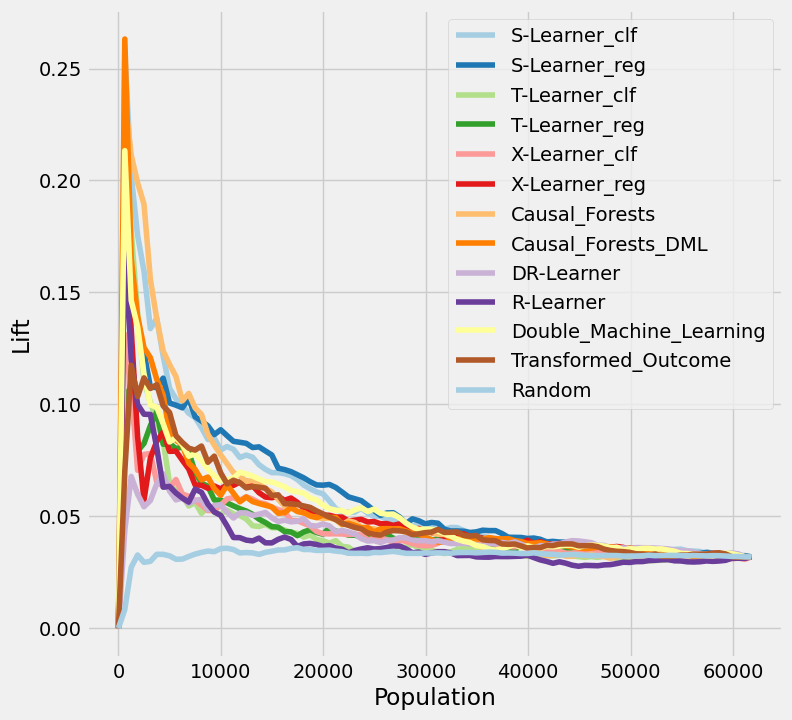

In [79]:
plot_lift(test_df,
          outcome_col= outcome_col,      #name of the column indicating the outcome variable
          treatment_col= treatment_col)  #name of the column indicating the treatment assignment

**We cannot see much here, we will plot only the best performers as ranked by AUUC (see next section)**

## 4.2 Area Under the Uplift Curve (AUUC)

The area under the uplift curve can be calculated using the CumulativeLift chart above. In particular, it is the area encapsulated by the uplift curve of a $\text{CATE}$ model and the uplift curve produced by random sampling (i.e., the *Random* line). The bigger this area is, the better a model is considered to be as it produces a *bigger* uplift.

**Note**: In the implementation of this metric in the *causalml* library, the function `auuc_score` calculates the area betwen the x-axis and each uplift curve without subtracting the area produced by the *Random* line. This still preserves the correct ranking of the models since the area between random sampling and the x-axis is constant (the same) for all $\text{CATE}$ models and subtracting a constant from the areas of the uplift curves will not affect the ranking, only the absolute value of auuc. The area does not have a very useful meaning anyway, it is only used to rank models, hence either variation is correct.

In [80]:
auuc_df = pd.DataFrame()

auuc_df['AUUC']= auuc_score(test_df,
           outcome_col=outcome_col,
           treatment_col=treatment_col)


# print("AUUC for S_Learner", auuc_df['AUUC']['S_Learner'] -  auuc_df['AUUC']['Random'])

auuc_df.sort_values('AUUC', ascending=False).style.highlight_max(color='red', axis=0)

,AUUC
S-Learner_reg,0.687423
S-Learner_clf,0.671970
Double_Machine_Learning,0.643239
X-Learner_reg,0.627232
Transformed_Outcome,0.624189
Causal_Forests_DML,0.621060
Causal_Forests,0.606742
DR-Learner,0.599197
T-Learner_reg,0.590711
X-Learner_clf,0.584922


Here we see that the 5 best performing models are 
1. the S-Learner with a regressor for fitting outcomes (instead of a classifier), 
2. the Linear Double Machine Learning model, 
3. the X-Learner with a regressor for outcome modeling, 
4. the Transformed Outcome,
5. The causal forests with local centering. 

We will use these models for our policy learning later on.

**Let's plot again the 5 best models**

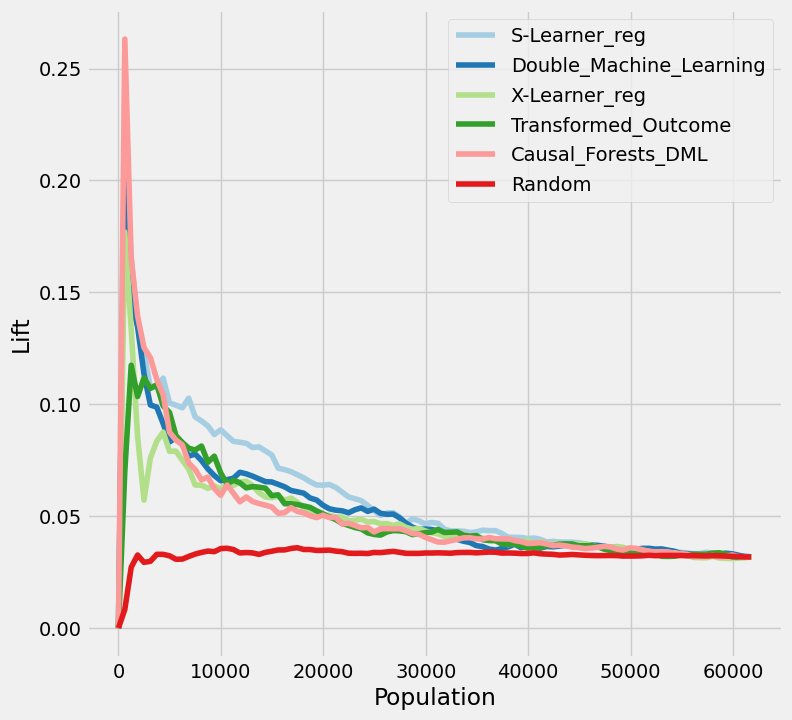

In [84]:
plot_lift(test_df[[outcome_col, treatment_col,
                    'S-Learner_reg', 'Double_Machine_Learning',
                    'X-Learner_reg', 'Transformed_Outcome',
                    'Causal_Forests_DML']],
          outcome_col= outcome_col,      #name of the column indicating the outcome variable
          treatment_col= treatment_col)  #name of the column indicating the treatment assignment

The red curve shows how much uplift (increase in conversion) we can generate when sampling randomly from the target population. As expected, the uplift achieved is constant and close to the overall $\text{ATE}=$ 3.12%. In contrast, if we follow the light-blue line (correspodning to the best performing model), we can see that when targeting the first 20,000 samples as ranked by the estimated treatment effects, we achieve  an $\text{ATE} \geq$ 5%. For the first 10,000 samples, the model achieves an $\text{ATE}$ close to 8%, and for the first 5000 samples an $\text{ATE}$ close to 10%. The higher the area between the *Random* line and our $\text{CATE}$ estimator, the better the model can target the samples for which the intervention is most effective.

## 4.3 Cumulative Gain
 
$\text{CumulativeGain}_{i} = (\frac{Y_T}{N_T} - \frac{Y_C}{N_C})\cdot(N_C + N_T) =\text{ATE}_{i} \cdot i $

The cumulative gain multiples the $\text{ATE}$ with the number of samples under consideration $i$ to obtain the estimated number of additional conversions that we would achieve by treating all samples until sample $i$ compared to not treating anyone. Eventually, the additional number of conversions will be equal to the $\text{ATE}\cdot N_{\text{holdout}}$. A good $\text{CATE}$ model will produce the majority of the additional conversions early on.

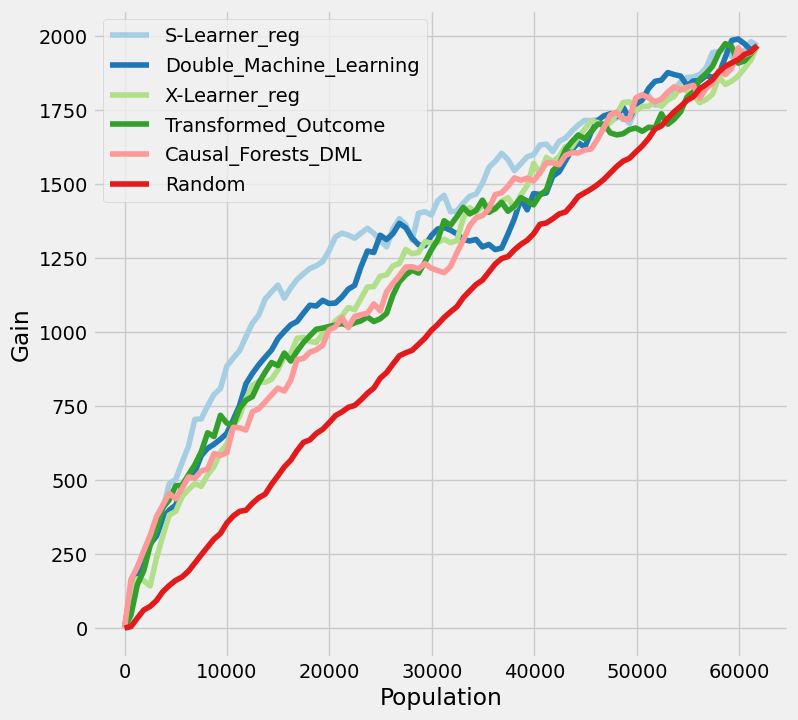

In [85]:
plot_gain(test_df[[outcome_col, treatment_col,
                    'S-Learner_reg', 'Double_Machine_Learning',
                    'X-Learner_reg', 'Transformed_Outcome',
                    'Causal_Forests_DML']],
          outcome_col= outcome_col,      #name of the column indicating the outcome variable
          treatment_col= treatment_col)

An example of how to read this chart is that at 20,000 samples as selected by the S-Learner, if we had choosen to treat all of them we would have achieved 1250 additional conversions versus not treating anyone.

## 4.4 (Adjusted) Qini Curve and Qini Score

$\text{Qini}_{i} = Y_{T} - \frac{Y_{C}\cdot N_{T}}{N_C}$

The Adjusted Qini curve estimates the additional number of conversions obtained by treating everyone in a sample of size $N_{T}$ versus not treating anyone in a sample of equal size.The Qini score is the area between the Qini curves of a model and random curve, i.e., the curve where samples are randomly selected as opposed to targeted selection.


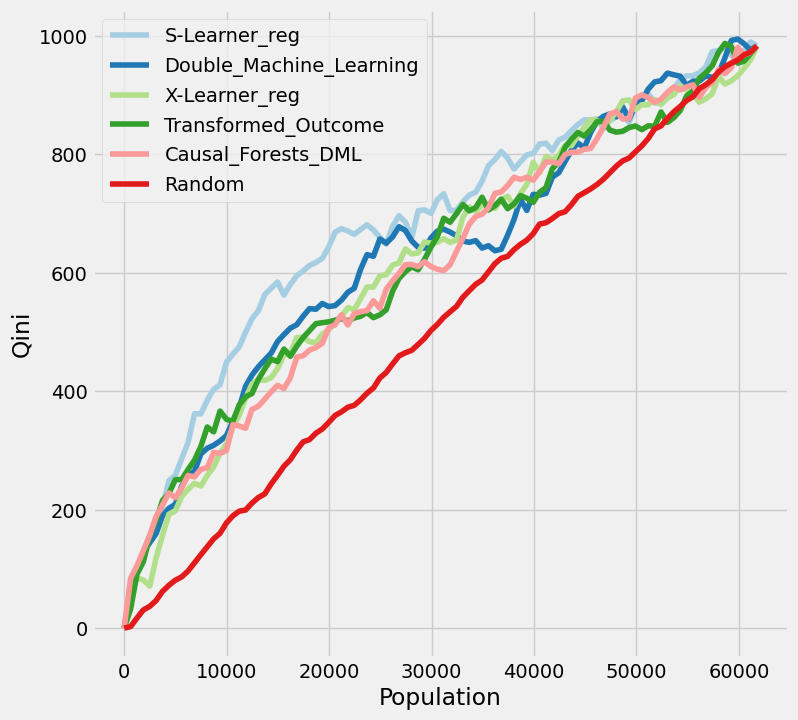

In [86]:
plot_qini(test_df[[outcome_col, treatment_col,
                    'S-Learner_reg', 'Double_Machine_Learning',
                    'X-Learner_reg', 'Transformed_Outcome',
                    'Causal_Forests_DML']],
          outcome_col= outcome_col,      #name of the column indicating the outcome variable
          treatment_col= treatment_col)

# 5. Bootstrap Sampling Function

In [91]:
from sklearn.utils import resample
from sklearn.model_selection import ShuffleSplit

In [107]:
def get_bootstrap_samples(X, T, N=10,train_size=0.7):

    datasets = {}
    
    # the function reshuffles the original dataset and splits it into train/test N times
    s_split = ShuffleSplit(n_splits=N, train_size=train_size, test_size= 1 - train_size, random_state=331)

    # for each train/test split, I bootstrap them once and consider those to be the final train/test sets.
    for i, (train_index, test_index) in enumerate(s_split.split(X, T)):
        datasets[i] = {'train':0,
                       'test':1}
        
        datasets[i]['train'] = resample(X.loc[train_index].index, random_state=3)
        datasets[i]['test']  = resample(X.loc[test_index].index, random_state=3)

    return datasets




# get boostrap datasets
datasets = get_bootstrap_samples(X.loc[index_to_keep].reset_index(drop=True), T[index_to_keep].reset_index(drop=True), N=1000) 

# 6. Policy Learning

While a $\text{CATE}$ estimator might be able to generate uplift compared to random sampling, that still does not answer the question of which samples we should treat. The out-of-sample evaluation allows us to confirm mainly that the model has captured some (true) heterogeneity. However, when our goal is **profitability**, to make the optimal decision on whom to treat, we must consider two extra parameters: the treatment cost per sample $C$ and the revenues generated by the response/outcome variable $R$ per sample.

Under the assumption that $C$ and $R$ are independent of $X$, i.e., the cost of treatment and revenues generated through the response are the same for all samples, one can arrive at the conclusion that we should treat only those samples for which:

$$\tau(X) \geq \frac{C}{R}$$

To understand this inequality intuitively, think for a moment of all samples in the population for which $X=x$, where $x$ is a fixed covariate profile. If there exists $A$ such samples, then let's compare the profits of treating all $A$ samples versus not treating any of them. Let's keep in mind that we estimate the same $\tau$ for all of them, since we can only model heterogeneity up to the level of detail that the observed covariates $X$ allow. Any further nuances that might exist are not available to us.

$$\text{Profits(T=1)} = A\cdot ({\text{ConvRate}(X)_{T=1} \cdot R - C} )$$
$$\text{Profits(T=0)} = A\cdot ({\text{ConvRate}(X)_{T=0} \cdot R - C} )$$

$$\text{Profits(T=1)} -\text{Profits(T=0)} = A\cdot ({\text{ConvRate}(X)_{T=1} \cdot R - C} ) - A\cdot ({\text{ConvRate}(X)_{T=0} \cdot R - C}) $$
$$\text{Profits(T=1)} -\text{Profits(T=0)} = A \cdot (R\cdot(\text{ConvRate}(X)_{T=1}  - \text{ConvRate}(X)_{T=0}) -C) $$
$$\text{Profits(T=1)} -\text{Profits(T=0)} = A \cdot (R\cdot\tau(X)-C) $$

If we want our profit difference to be positive, then we require that $A \cdot (R\cdot\tau(X)-C) \geq 0$ which leads to $\tau(X) \geq \frac{C}{R}$

In other words, given a covariate profile $x$, we choose whether to treat all or none of the samples with that covariate profile based on whether their conversion rate increases more than the fraction $\frac{C}{R}$ when they receive the treatment.

If $\tau(X) < \frac{C}{R}$, we incur losses by deciding to treat the subpopulation with $X=x$    


If $\tau(X) > \frac{C}{R}$, we increase profits by deciding to treat the subpopulation with $X=x$

Given $C$ and $R$, we can obtain a clear threshold on whom we should treat when our goal is profitability. In reality, however, we only have noisy estimates $\hat{\tau}(X)$ and so we have to evaluate how good/profitable our targeting policy is when implementing $\hat{\tau}(X) \geq \frac{C}{R}$.




___

### Targeting Policies 
What we discussed previously gives rise to a simple yet potentially very effective targeting policy.

**First targeting policy**
1. Estimate $\tau(X)$ via one of the $\text{CATE}$ estimators
2. Create a policy where only the samples with $\hat{\tau}(X) \geq \frac{C}{R}$ get treated.
3. Estimate profits on a hold-out sample based on off-policy evaluation methods (here we will use Inverse Propensity Scoring because data is randomised; otherwise, we need to consider doubly-robust evaluation)

**Second targeting policy**  

There is also one more thought that can be added to the targeting policy above. Missclassifying samples with $\tau(X)$ close to $\frac{C}{R}$ has a lower cost than missclassifying samples with $\tau(X)$ much higher than $\frac{C}{R}$ because the latter group would have been much more profitable if it was targeted. Hence, a second policy learning approach is to assign a label of 1 to all samples with $\hat{\tau}(X) \geq \frac{C}{R}$ and the rest 0, and then estimate a **weighted** classification model where the higher the profit/loss of a specific covariate profile $X$ is , the higher is also its significance to the model.

___

### Policy Evaluation



There are broadly two ways to evaluate policies

___

### Approach and questions 
In what follows, we will implement both learning policies and evaluate their performance. We will be doing that using a boostrap approach to get an estimate of the uncertainity surrounding our estimation of treatment effects and profitability of the learned targeting. In the end, we will be interested in the following questions:

- Which $\text{CATE}$ estimator achieves the most profitable targeting?
- What are the expected profits from implementing the best estimator?
- What is the estimated probability of incurring losses through the application of the best targeting policy?
 

___

In [69]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

### 6.0 Cost/Revenue Parameters and ATE of the experiment

In [117]:
print('ATE:', Y[T==1].sum() / len(Y[T==1]) - Y[T==0].sum() / len(Y[T==0]))
cost_data = [(1, 25), (1,20), (1,15), (1,30)]

ATE: 0.031158243682944398


### 6.1 Functions for building policies based on the two approaches outlined above

#### 6.1.1 Policy 1

In [82]:
def build_policy(data, threshold):
    policy = pd.Series(data).apply(lambda x: 1 if x>= threshold else 0).values
    return policy

#### 6.1.2 Policy 2

In [118]:
def build_policy_2(Y_train,
                   effects_train, 
                   threshold,
                   treatment_cost,
                   positive_outcome_profit):
    

    # new labels based on who should be treated
    Y_train.loc[:] = pd.Series(effects_train).apply(lambda x: 1 if x>= threshold else 0).values 
    sample_weight = np.abs(positive_outcome_profit*effects_train - treatment_cost).flatten()


    xgb_classifier = XGBClassifier()

    # Define parameter grid for grid search
    param_grid = {
        'n_estimators': [1000],
        'learning_rate': [0.2, 0.5],
        'max_depth': [ 5, 7, 10]
    }


    # Define K-fold cross-validation
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=xgb_classifier, 
                            param_grid=param_grid, 
                            cv=kfold, 
                            scoring='accuracy', 
                            n_jobs=-1)

    grid_result = grid_search.fit(X_train, 
                                  Y_train,
                                  sample_weight= sample_weight)

    # Get the best parameters and the best score
    best_params = grid_result.best_params_
    best_score = grid_result.best_score_

    print("Best Parameters:", best_params)
    print("Best Accuracy:", best_score)

    # Evaluate the tuned model on the test set
    tuned_model = grid_result.best_estimator_
    policy= tuned_model.predict(X_test)

    
    return policy

### 6.2 Function for calculating the inverse propensity weighted profits given a policy

In [84]:
def evaluate_policy(policy,
                    treatment_assignment,
                    outcome,
                    propensities,
                    treatment_cost,
                    positive_outcome_profit):
    """
    policy (numpy.array, shape= (n,)):
    treatment_assignment (numpy.array, shape= (n,)):
    outcome (numpy.array, shape= (n,)):
    propensities (numpy.array, shape= (n,)):
    treatment_cost (float): cost of providing treatment to a sample
    positive_outcome_profit (float): marginal profit from conversion
    """

    treatment_col = 'treatment'
    propensity_col = 'propensity'
    outcome_col = 'outcome'
    policy_col  ='policy'

    data = np.vstack([treatment_assignment,
               policy,
               propensities,
               outcome]).T
    

    data = pd.DataFrame(data =data,
        columns  = [treatment_col, policy_col, propensity_col, outcome_col])


    # use inverse propensity scoring to calculate profits for 
    profits = data.apply(lambda x: ( (1-x[treatment_col]) * (1-x[policy_col]) / (1- x[propensity_col]) * positive_outcome_profit * x[outcome_col] + 
                            (x[treatment_col]/x[propensity_col] * x[policy_col] * (positive_outcome_profit * x[outcome_col]-treatment_cost)) ) , axis=1).sum()


    return profits


### 6.3 CATE Models

In [120]:
models = {'s-learner': SLearner(overall_model=XGBRegressor(random_state=3)),
          

          'double_machine_learning': LinearDML(model_y= XGBClassifier(),
                model_t= XGBClassifier(),
                discrete_treatment=True,
                discrete_outcome=True,
                random_state=123),
          
          'x-learner':XLearner(models = [XGBClassifier(), XGBClassifier()],
                        cate_models =   [XGBRegressor(), XGBRegressor()],
                        propensity_model=  XGBClassifier()),
          
          'causal_forest': CausalForest(criterion='het', n_estimators=400, min_samples_leaf=5, max_depth=None,
                   min_var_fraction_leaf=None, min_var_leaf_on_val=True,
                   min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                   warm_start=False, inference=True, fit_intercept=True, subforest_size=4,
                   honest=True, verbose=0, n_jobs=-1, random_state=1235)
            
}


### 6.4 Main Loop for calculating OPE (takes hours to run!)

In [138]:
# profits_df = pd.DataFrame()

# for costs in cost_data:
#         C = costs[0]
#         R = costs[1]

#         for model_name, model in models.items():
        
#             for i in range(50):

#                     profits_df.loc[i, 'cost_reward_ratio'] = C/R

#                     # get bootstrapped datasets
#                     X_train = X_scaled.loc[datasets[i]['train']].copy()
#                     Y_train = Y.loc[datasets[i]['train']].copy()
#                     T_train = T.loc[datasets[i]['train']].copy()

#                     X_test = X_scaled.loc[datasets[i]['test']].copy()
#                     Y_test = Y.loc[datasets[i]['test']].copy()
#                     T_test = T.loc[datasets[i]['test']].copy()

#                     ## TREAT NOONE policy
#                     policy = np.zeros(shape = (len(X_test),))

#                     # profits for treat none policy
#                     profits = evaluate_policy(
#                                     policy,
#                                     T_test.values,
#                                     Y_test.values,
#                                     0.5 * np.ones(shape=(len(X_test),)),
#                                     treatment_cost = C,
#                                     positive_outcome_profit=R)

#                     profits_df.loc[i, ['treat_none', 'treat_none_phi']] = profits, 0


#                     ## TREAT ALL POLICY
#                     policy = np.ones(shape = (len(X_test),))

#                     # profits for treat all
#                     profits = evaluate_policy(
#                                     policy,
#                                     T_test.values,
#                                     Y_test.values,
#                                     0.5 * np.ones(shape=(len(X_test),)),
#                                     treatment_cost = C,
#                                     positive_outcome_profit=R)

#                     profits_df.loc[i, ['treat_all', 'tret_all_phi']] = profits, 1


#                     ## CATE MODELS
                    

#                     try:
#                             model.fit(X=X_train,
#                                     Y=Y_train,
#                                     T=T_train)
#                     except:
#                             model.fit (X=X_train,
#                                     y=Y_train,
#                                     T=T_train)         
                                    
                            

#                     # Build and evaluate Policy 1 (tau > c/r)
#                     try:
#                             taus_test = model.effect(X_test).reshape((len(X_test,)))
#                     except:
#                             taus_test = model.predict(X_test).reshape((len(X_test,)))

#                     policy_1 = build_policy(taus_test, threshold=C/R)
#                     phi_1 = (policy_1 == 1).sum() / len(policy_1)
#                     profits_1 = evaluate_policy(
#                             policy_1,
#                             T_test.values,
#                             Y_test.values,
#                             0.5 * np.ones(shape=(len(X_test,))),
#                             treatment_cost = C,
#                             positive_outcome_profit=R)
                    
#                     # store profits and phi for Policy 1
#                     profits_df.loc[i,[model_name + '_policy_1', model_name + '_policy_1_phi']] = profits_1, phi_1


#                     # Build and evaluate Policy 2 (fitted model)
#                     try:
#                             taus_train = model.effect(X_train).reshape((len(X_train,)))
#                     except:
#                             taus_train = model.predict(X_train).reshape((len(X_train,)))
                            
#                     policy_2 = build_policy_2(Y_train, taus_train, threshold=C/R, treatment_cost=C, positive_outcome_profit=R)
#                     phi_2 = (policy_2 == 1).sum() / len(policy_2)
#                     profits_2 = evaluate_policy(
#                             policy_2,
#                             T_test.values,
#                             Y_test.values,
#                             0.5 * np.ones(shape=(len(X_test,))),
#                             treatment_cost = C,
#                             positive_outcome_profit=R)

#                     # store profits and phis for Policy 2
#                     profits_df.loc[i,[model_name + '_policy_2', model_name + '_policy_2_phi']] = profits_2, phi_2

Best Parameters: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 1000}
Best Accuracy: 0.9574233785779308
Best Parameters: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 1000}
Best Accuracy: 0.9641063483041373
Best Parameters: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 1000}
Best Accuracy: 0.9629236578630794
Best Parameters: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 1000}
Best Accuracy: 0.9648029992180568
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 1000}
Best Accuracy: 0.9702465690851279
Best Parameters: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 1000}
Best Accuracy: 0.9661720018747427
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 1000}
Best Accuracy: 0.9731060924990403
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 1000}
Best Accuracy: 0.9652647299280771
Best Parameters: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 1000}
Best Accuracy: 0.965

___

## Some extra thoughts about targeting!

1) The outcome variable can be more complex, yet the rule $\tau(X) \geq \frac{C}{R}$ is still useful. Consider the case where the treatment is an email attempting to make a customer subscribe to store's newsletter. The outcome variable can be the amount of $ spent over the whole next year which is practically the 1-year CLV estimate. What is more, one can even model $R$ as $R(X)$, which leads to a more informative rule of $\tau(X) \geq \frac{C}{R(X)}$.  In all of these cases the rule can provide a good targeting threshold.

2) The threshold rule is still useful when profitability is not the single goal. Consider the case of Spotify and student discounts. Spotify halves the prices for students with the goal of increasing the number of subscribers at first, even if that incurs short-term losses. During the student years, each subscribed student is costing the company money. However, when their student version ends, Spotify bets on the customer sticking with the product at double the price they previously paid. Assuming that the full price is indeed profitable for the company, one can still calculate the threshold using the rule $\tau(X) \geq \frac{C}{R}$. In this case :

$$R= \sum_{i=1}^{\text{T}_\text{student}(X)}  \frac{\text{Half Sub Price}(X)}{(1 - t)^i} + P(\text{conversion to full price}) \cdot \sum_{i=\text{T}_\text{student}+1}^{\text{T}_\text{full price}(X)}  \frac{\text{Full Sub Price}(X)}{(1 - t)^i} $$

where:

- $\text{T}_\text{student}(X)$: Average number of student years for students with $X=x$ (think $X$ being the country of studies, type of studies  etc.)
- $\text{T}_\text{full price}(X)$: Average number of years that a paid customer with covariate profile $X=x$ stays with Spotify at full price

The Revenues $R$ are in this case the discounted cash flows from the two periods, one being the student years, the other being the expected lifetime of a customer after the student years. This is but one approach for summarising revenues in $R$, but we see that we can actually capture a much more complex scenario in  a single number.

Similarly:  

$$C = \sum_{i=1}^{\text{T}_\text{student}(X)} \frac{\text{Cost of serving a customer}(X)}{(1 - t)^i} +P(\text{conversion to full price}) \cdot \sum_{i=\text{T}_\text{student}+1}^{\text{T}_\text{full price}(X)} \frac{\text{Cost of serving a customer}(X)}{(1 - t)^i} $$


Even in this much more complicated scenario spanning over multiple years, the targeting rule provides an informative threshold of the lift required for this intervention (halving the price) to be profitable in the long run.

___

# Shap Values for the best performing models (causal forests and s-learner)

In [37]:
import shap

### Retrain causal forests and s-learner on the initial train-test split

#### s-learner

In [4]:
from econml.metalearners import SLearner 

In [8]:
s_learner_ec = SLearner(overall_model=XGBRegressor(random_state=3))

s_learner_ec.fit(X=X_train,
        Y=Y_train,
        T=T_train)

### Shap Values

In [10]:
sv_s_learner = s_learner_ec.shap_values(X_test)

PermutationExplainer explainer: 61760it [53:02, 19.33it/s]                             


In [18]:
# import joblib

# # save explainer
# ex_filename = 's_learner_shap.bz2'
# joblib.dump(sv_s_learner, filename=ex_filename, compress=('bz2', 9))

# ## Load explainer
# ex= joblib.load(filename=ex_filename)

['s_learner_shap.bz2']

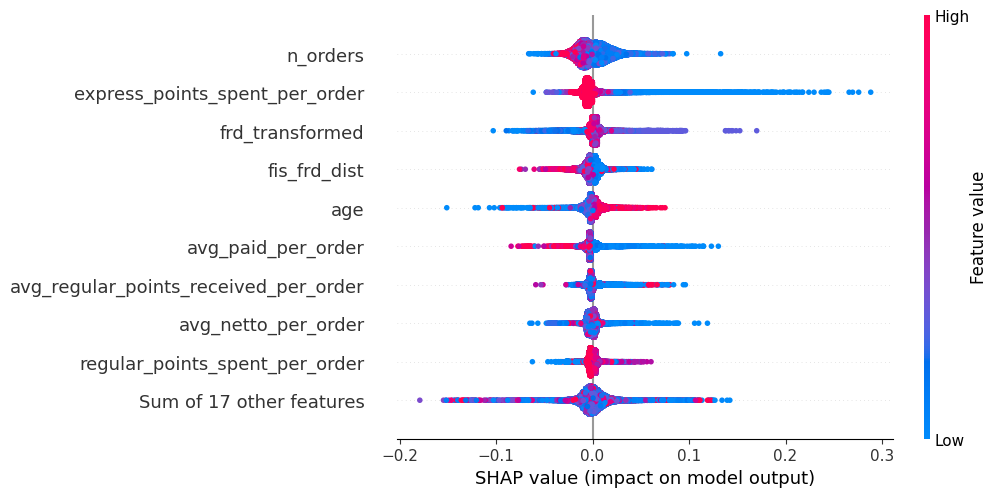

In [45]:
shap.plots.beeswarm(sv_s_learner['target']['treatment_flg_1'])